# Estimation of equivalent birth-death time-dependent rates on the protracted birth-death model
Pierre Veron `pveron@bio.ens.psl.eu`. 

## 1 Probabilities of speciation and extinction within a horizon in the BD model

We consider a simple constant birth-death (BD) model with rates $\lambda$ and $\mu$. 

Let us introduce $p^{BD}_S(t), p^{PB}_E(t)$ and $p^{BD}_N (t)$ the probability of speciation before time $t$, extinction before time $t$ and no event before time $t$. We have
$$p^{BD}_S(t) = \frac{\lambda}{\lambda+\mu} (1 - e^{-(\lambda + \mu) t}), \quad p^{BD}_E(t) = \frac{\mu}{\lambda+\mu} (1 - e^{-(\lambda + \mu) t}) \quad \text{and} \quad p^{BD}_N(t) = e^{-(\lambda + \mu) t}.  $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
plt.style.use("customstyle")
import sys
sys.path.append("../modules")
import PBD_analog
import graph_tools
import scipy.integrate
import scipy.optimize
import matplotlib as mpl
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

colors = ['#000000','#cf5c36','#bcd696','#985f99','#9684a1']
palette = ['#FFCE00','#0064B0','#9F9825','#98D4E2','#C04191','#F28E42','#83C491',
'#F3A4BA','#83C491','#CEADD2','#D5C900','#E3B32A','#8D5E2A','#00814F',
'#98D4E2','#662483','#B90845','#F3A4BA','#D5C900','#00A88F']

np.random.seed(921)

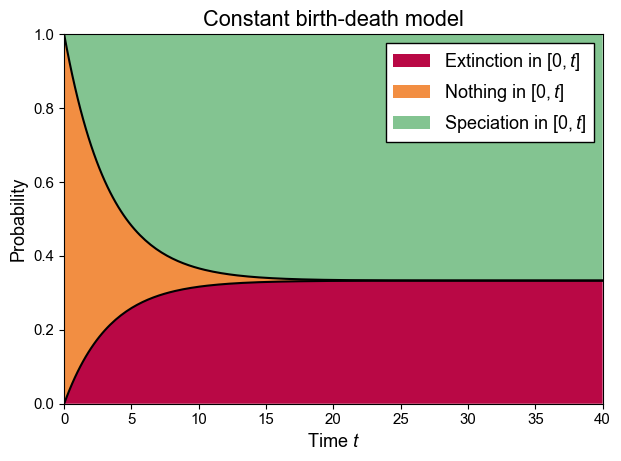

In [2]:
T = np.linspace(0,40,200)
l = 0.2
m = 0.1

pBDS = l / (l + m) * (1-np.exp(-(l+m)*T))
pBDE = m / (l + m) * (1-np.exp(-(l+m)*T))
pBDN = np.exp(-(l+m)*T)


fig, ax = plt.subplots()

ax.fill_between(T, 0.0, pBDE, fc = palette[16], label = "Extinction in $[0,t]$")
ax.fill_between(T, pBDE, pBDE + pBDN, fc = palette[5], label = "Nothing in $[0,t]$")
ax.fill_between(T, 1.0 - pBDS, 1.0, fc = palette[6], label = "Speciation in $[0,t]$")

ax.plot(T, pBDE, color = "k", lw = 1.5)
ax.plot(T, pBDE + pBDN, color = "k", lw = 1.5)

ax.legend()
ax.set_xlabel("Time $t$")
ax.set_ylabel("Probability")
ax.set_xlim(T[0], T[-1])
ax.set_ylim(0,1)
ax.set_title("Constant birth-death model")
plt.savefig("../fig/horizon_BD_probs.pdf");

*__Figure 1.__ Possible outcomes and their probability in the BD model within a time horizon $[0,t]$.*

## 2 Probabilities of speciation and extinction in the PBD model. 
### 2.1 Notations.
We will use the following definitions:
* "extinction" means that one lineage and all its possible descendents die,
* for an incipient lineage, "completion" means that this good lineage or any direct or indirect desendents completes speciation
* for a good lineage "speciation" means that this good lineage forms at least one incipient lineage that completes.

We look at the outcomes within a _horizon_ $t$. 
* Starting with a __good__ lineage, the possible outcomes are:
    * extinction before a time $t$, this happens with a probability $p^G_E(t)$,
    * speciation before a time $t$, this happens with a probability $p^G_S(t)$, 
    * no speciation or extinction before a time $t$, this happens with a probability $p^G_N(t)$.



We note that for any $t>0$, $p^G_E(t) + p^G_S(t) + p^G_N(t) = 1$. 

* Starting with an __incipient__ lineage, the possible outcomes are:
    * extinction before a time $t$, this happens with a probability $p^I_E(t)$,
    * completion before a time $t$, this happens with a probability $p^I_C(t)$, 
    * no completion or extinction before a time $t$, this happens with a probability $p^I_N(t)$.

We also have for any $t>0$, $p^I_E(t) + p^I_S(t) + p^I_N(t) = 1$. 

We also introduce the sum of the rates for an incipient lineage:
$$\Lambda := \lambda_2 + \lambda_3 + \mu_2$$
and for a good lineage 
$$\Theta := \lambda_1 + \mu_1.$$

![Examples of the possible outcomes within a horizon $t>0$](./schema_horizon.png)
_**Figure 2.** Examples of the possible outcomes within a horizon $t>0$._

We finally find the initial conditions that will be helpful to solve the equations for the probability: when $t\to 0$, the probability of speciation/completion or extinction goes to 0 and it is likely that nothing happens, so we set:
$$p^G_E(0) = p^G_S(0) = p^I_E(0) = p^I_C(0) = 0$$
and 
$$ p^G_N(0) = p^I_N(0) = 1.$$

### 2.2 Extinction probabilities
Starting from an incipient lineage: the two exclusive possible ways leading to extinction within a horizon $t$ are: 
* the lineage directly goes extinct within a time $t$, it happens with a probability $\frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t})$, or
* the lineage forms two incipient lineage at a time $u \le t$ and both incipient lineages go extinct within the remaining time $t-u$. The density of that event is
$$\lambda_3 e^{-\Lambda u} (p^I_E(t-u))^2. $$

Therefore we have the following equation

$$
    p^I_E(t) = \frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t}) + \int_0^t \lambda_3 e^{-\Lambda u} (p^I_E(t-u))^2 d u \\
    = \frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t}) + \lambda_3 e^{-\Lambda_ t} \int_0^t e^{\Lambda u} (p^I_E(u))^2 d u. 
$$

Let us define $F:t\mapsto \int_0^t e^{\Lambda u} (p^I_E(u))^2 du$. The function $F$ is a solution to the ODE:
$$\sqrt{e^{-\Lambda t} F'(t)} = \frac{\mu_2}{\Lambda} \left( 1 -e^{-\Lambda t}\right) + \lambda_3 e^{-\Lambda t} F(t)$$
with $F(0) = 0$. This ODE can be solved analytically with Mathematica, so we find an analytical solution for $p_E^I(t) = \sqrt{e^{-\Lambda t} F'(t)}$ :
$$p_E^I(t) = \frac{1}{\lambda_3} \sqrt{\frac{c (\Lambda - k) e^{kt} + \Lambda/k}{\left(c e^{kt} + 1/k \right)^2} - \frac{\Lambda(k-\Lambda) + 2\mu_2\lambda_3}{2}}$$
with $k = \sqrt{\Lambda^2 - 4  \mu_2\lambda_3}$ and $c = \frac{2}{k-\Lambda} - \frac{1}{k}$. 

Applying the same reasonning to good lineages, we have:
$$p^G_E(t) = \frac{\mu_1}{\Theta} ( 1 - e^{-\Theta t}) + \lambda_1 e^{-\Theta t}  \int_0^t e^{\Theta u} p^I_E(u) p^G_E(u) d u.$$

We have no analytical solution for this equation but it can be solved numerically but we have to write it as an ordinary differential equation (ODE). To do this, let's use a logarithmic change of variable:
$$ \int_0^t e^{\Theta u} p^I_E(u) p^G_E(u) d u = \int_1^{e^{\Theta t}} \frac{1}{\Theta} p^I_E\left(\frac{\log v}{\Theta}\right) p^G_E\left(\frac{\log v}{\Theta}\right) d v.$$

Let us introduce $f:x\mapsto \int_1^x \frac{1}{\Theta} p^I_E\left(\frac{\log v }{\Theta}\right) p^G_E\left(\frac{\log v}{\Theta}\right) d v$. We then have the ODE
$$f'(x) = \frac{1}{\Theta} p_E^I \left( \frac{\log x}{\Theta} \right) \left( \frac{\mu_1}{\Theta} \left( 1 - \frac{1}{x} \right) + \frac{\lambda_1}{x} f(x) \right)$$
and the initial condition $f(1) = 0$. 

We can solve this ODE numerically and calculate $p^G_E(t) = \Theta f'(e^{\Theta t}) / p^I_E(t)$. 

### 2.3 Speciation/completion probabilities
Starting from an incipient, we will rather calculate the probability of not completing $1 - p_C^I(t)$. This event can be decomposed in three exclusive outcomes:
* direct extinction of the lineage in $[0,t]$, this happens with a probability $\frac{\mu_2}{\Lambda} (1 - e^{-\Lambda t})$, or
* the lineage survives until $t$ without completing, dying or making incipient lineages, this happens with probability $e^{-\Lambda t}$, or 
* the lineage makes an incipient at a time $u\le t$ and none of the incipient daughter lineages complete within the remaining time, the density probability of this outcome is $\lambda_3 e^{-\Lambda u} ( 1 -p_C^I(t-u))^2$.


So we have the following equation:
$$
    1 - p_C^I(t) = \frac{\mu_2}{\Lambda} (1 - e^{-\Lambda t})  + e^{-\Lambda t} + \int_0^t \lambda_3 e^{-\Lambda u} ( 1 -p_C^I(t-u))^2 du \\
     = \frac{\mu_2}{\Lambda} (1 - e^{-\Lambda t})  + e^{-\Lambda t} + \lambda_3 e^{-\Lambda t} \int_0^t  e^{\Lambda u} ( 1 -p_C^I(u))^2 du
$$

Now starting from a good lineage, the only way to speciate is to first initiate speciation at a time $u\le t$. The probability density of that event is $\lambda_1 e^{-\Theta u}$. Then:
* this incipient lineage or one of its descendants complete speciation within the remaining time, with probability $p^I_C(t-u)$, or
* this incipient lineage does not complete (with probability $1-p^I_C(t-u)$) and the good lineage at the origin must start the speciation process again: this happens with probability $p_S^G(t-u)$.

So
$$
    p_S^G(t) = \int_0^t \lambda_1 e^{-\Theta u} \left[ p_C^I(t-u) + (1-p_C^I(t-u)) p_S^G(t-u) \right] du \\
    = \lambda_1 e^{-\Theta t} \int_0^t e^{\Theta u} \left[ p_C^I(u) + (1-p_C^I(u)) p_S^G(u) \right] du.
$$

To estimate numerically $p_C^I(t)$ we can use the variable change $v = e^{\Lambda t}$ and by the same method as for $p_E^G$ we find that
$$p_C^I(t) = 1 - \sqrt{\Lambda g'(e^{\Lambda t})}$$
with $g$ being the solution on $[1, +\infty[$ of the ODE
$$g'(x) = \frac{1}{\Lambda} \left[\frac{\mu_2}{\Lambda} \left(1-\frac{1}{x}\right) + \frac{1}{x} + \frac{\lambda_3}{x} f(x)\right]^2$$
with $g(1) = 0$. 

Similarly, we solve $p^G_S(t)$ with the variable change $v = e^{\Theta t}$ and find that 
$$ p_S^G(t) = \frac{\Theta h'(e^{\Theta t}) - p^I_C(t)}{ 1 - p^I_C(t)}$$
with $h$ the solution on $[1, +\infty[$ of the ODE
$$h'(x) = \frac{1}{\Theta} \left[ p^I_C\left(\frac{\log x}{\Theta}\right)  + \frac{\lambda_1}{x} \left( 1 - p^I_C\left(\frac{\log x}{\Theta}\right)\right) h(x)  \right]$$
with $h(1) = 0$.

### 2.4 Simulations of the PBD model with horizons

In [3]:
# Parameters
l1, l2, l3, m1, m2 = 0.5, 0.8, 0.4, 0.2,0.2
T = np.linspace(0, 15, int(200)) #np.array([0] + list(np.geomspace(0.001,15, num = int(1e4))))
T_sim = np.linspace(0.05,15, 20) # list(np.linspace(0.01, 10, 10)) + list(np.linspace(15,60,10))
n_sim = int(10000)

par = dict(l1 = l1, l2 = l2, l3 = l3, m1 = m1, m2 = m2)
Lambda = l2 + l3 + m2
Theta = l1 + m1

  0%|          | 0/20 [00:00<?, ?it/s]

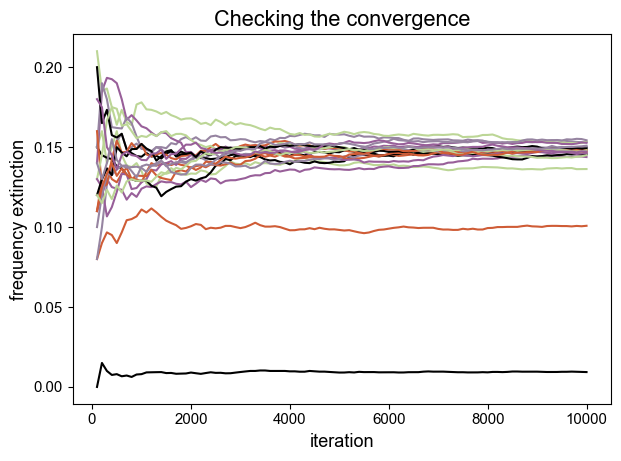

In [4]:
# Simulations (takes some time)
# -- Start with incipient lineage 
sim_param = {'n_sim':n_sim, 'step':int(n_sim / 100), 'n_g0':0, 'n_i0':1}
fig, ax = plt.subplots()

pIE_sim = np.zeros_like(T_sim)
pIC_sim = np.zeros_like(T_sim)

iter = np.linspace(sim_param['step'], sim_param['n_sim'], sim_param['n_sim'] // sim_param['step'])

for i in tqdm(range(len(T_sim))):
    sim = PBD_analog.simul_prot_etienne(**par, **sim_param, horizon=T_sim[i])
    ax.plot(iter, sim["F_extinction"], label = str(i))
    pIE_sim[i] = np.sum(sim["Extinction"]) / len(sim["Extinction"])
    pIC_sim[i] = np.sum(sim["Speciation"]) / len(sim["Speciation"])
ax.set_xlabel("iteration")
ax.set_ylabel("frequency extinction")
ax.set_title("Checking the convergence");

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\pveron\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pveron\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


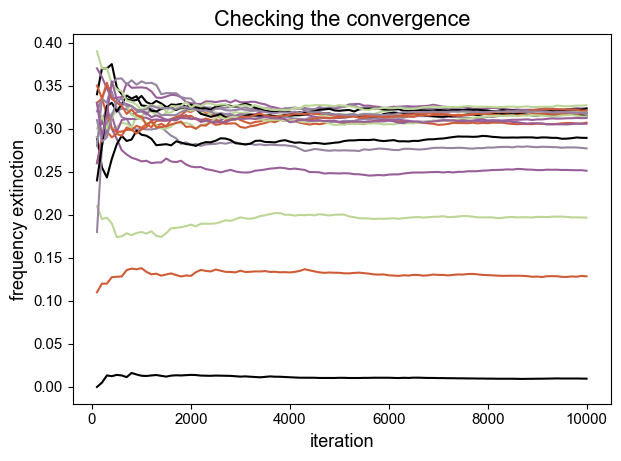

In [5]:
# Simulations (takes some time)
# -- Start with good lineage 
sim_param = {'n_sim':n_sim, 'step':int(n_sim / 100), 'n_g0':1, 'n_i0':0}

fig, ax = plt.subplots()
pGE_sim = np.zeros_like(T_sim)
pGS_sim = np.zeros_like(T_sim)

iter = np.linspace(sim_param['step'], sim_param['n_sim'], sim_param['n_sim'] // sim_param['step'])

for i in tqdm(range(len(T_sim))):
    sim = PBD_analog.simul_prot_etienne(**par, **sim_param, horizon=T_sim[i])
    ax.plot(iter, sim["F_extinction"], label = str(i))
    pGE_sim[i] = np.sum(sim["Extinction"]) / len(sim["Extinction"])
    pGS_sim[i] = np.sum(sim["Speciation"]) / len(sim["Speciation"])

ax.set_xlabel("iteration")
ax.set_ylabel("frequency extinction")
ax.set_title("Checking the convergence");

### 2.5 Numerical resolution of the ODEs

c:\Users\pveron\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


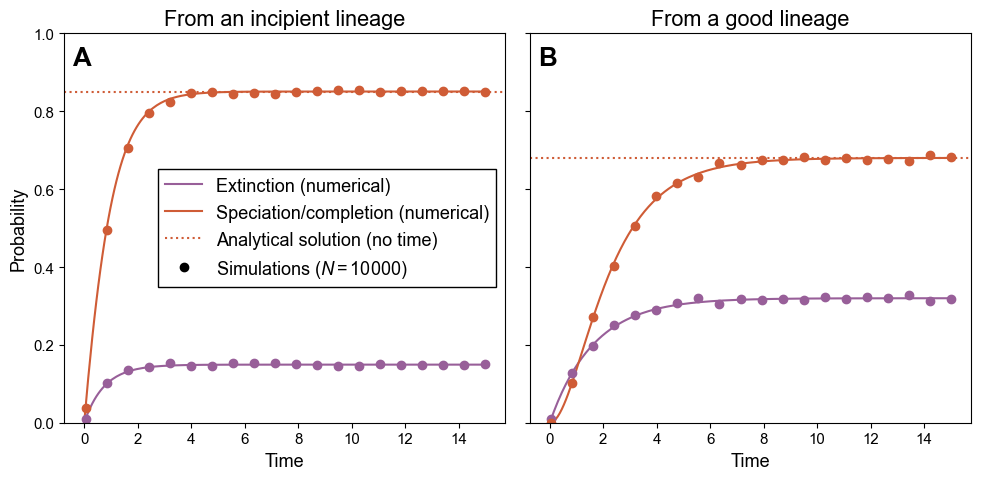

In [6]:
# Compute the solution 
probs = PBD_analog.PBD_to_probs(T, solver_kwargs= dict(atol = 1e-15, rtol = 1e-15), **par)

pi = PBD_analog.pi(**par)
pspec_inf = PBD_analog.p_speciation(**par)

fig, axes = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey=True)

axes[0].plot(probs["T"], probs["pIE"], color = colors[3], label = "Extinction (numerical)")
axes[0].plot(probs["T"], probs["pIC"], color = colors[1], label = "Speciation/completion (numerical)")
axes[1].plot(probs["T"], probs["pGE"], color = colors[3], label = "$p^G_E(t)$")
axes[1].plot(probs["T"], probs["pGS"], color = colors[1], label = "$p^G_S(t)$")

axes[0].axhline(1-pi, ls = ":",color = colors[1], label = "Analytical solution (no time)")
axes[1].axhline(pspec_inf, ls = ":", color = colors[1],  label = "$p_S^G(\\infty)$")

axes[0].plot(T_sim, pIE_sim, ls = "", marker = "o", color = colors[3])
axes[0].plot(T_sim, pIC_sim, ls = "", marker = "o", color = colors[1])
axes[1].plot(T_sim, pGE_sim, ls = "", marker = "o", color = colors[3])
axes[1].plot(T_sim, pGS_sim, ls = "", marker = "o", color = colors[1])

axes[0].plot([],[], marker = "o", ls = "", color = "k",label = "Simulations ($N = {}$)".format(n_sim))

axes[0].legend()


axes[0].set_title("From an incipient lineage")
axes[1].set_title("From a good lineage")

graph_tools.name_plot_corner(axes[0], 'A')
graph_tools.name_plot_corner(axes[1], 'B')

axes[0].set_ylabel("Probability")
axes[0].set_ylim(0,1)

for ax in axes:
    ax.set_xlabel("Time")

plt.savefig("../fig/SM_probabilities_vs_simulations.pdf")

*__Figure 3.__ Numerical solutions of the speciation/completion probabilities (solid lines) and comparison to the simulations (dots) and the analytical solutions without time horizons (dotted lines).*

We note that
$$\lim_{t\to \infty} p^G_E (t) = p_S$$
where $p_S$ is the probability of speciation that we calculated in the part without horizon, and
$$\lim_{t\to\infty} p^I_E(t) = \pi$$
where $\pi$ is the extinction probability established in the previous part. 

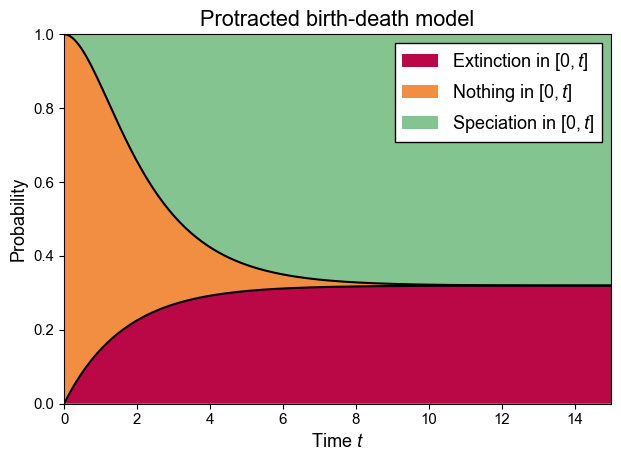

In [7]:
pGE, pGS = probs["pGE"], probs["pGS"]
pGN = 1.0 - pGE - pGS

fig, ax = plt.subplots()

ax.fill_between(T, 0.0, pGE, fc = palette[16], alpha = 1, label = "Extinction in $[0,t]$")
ax.fill_between(T, pGE, pGE + pGN, fc = palette[5], alpha = 1, label = "Nothing in $[0,t]$")
ax.fill_between(T, 1.0 - pGS, 1.0, fc = palette[6], alpha = 1, label = "Speciation in $[0,t]$")

ax.plot(T, pGE, color = "k", lw = 1.5)
ax.plot(T, pGE + pGN, color = "k", lw = 1.5)

ax.legend()
ax.set_xlabel("Time $t$")
ax.set_ylabel("Probability")
ax.set_xlim(T[0], T[-1])
ax.set_ylim(0,1)
ax.set_title("Protracted birth-death model");

*__Figure 4__. Outcomes of the PBD model within a time horizon [0,t].*

## 3. Estimation of rates through with comparison of probabilities

### 3.1 Fitting the probabilities with constant rates
Let us fit the equivalent BD model to the numerical solutions of speciation and extinction probability of the BD model. To do so we can determine the rates $(\lambda, \mu)$ so that $p^G_S(t) ~p^{BD}_S(t)$ for all the values of $t$. But we can also optimize $p^G_E(t) ~ p^{BD}_E(t)$. Here, we use the function `curve_fit` from the module `scipy` to do so. 

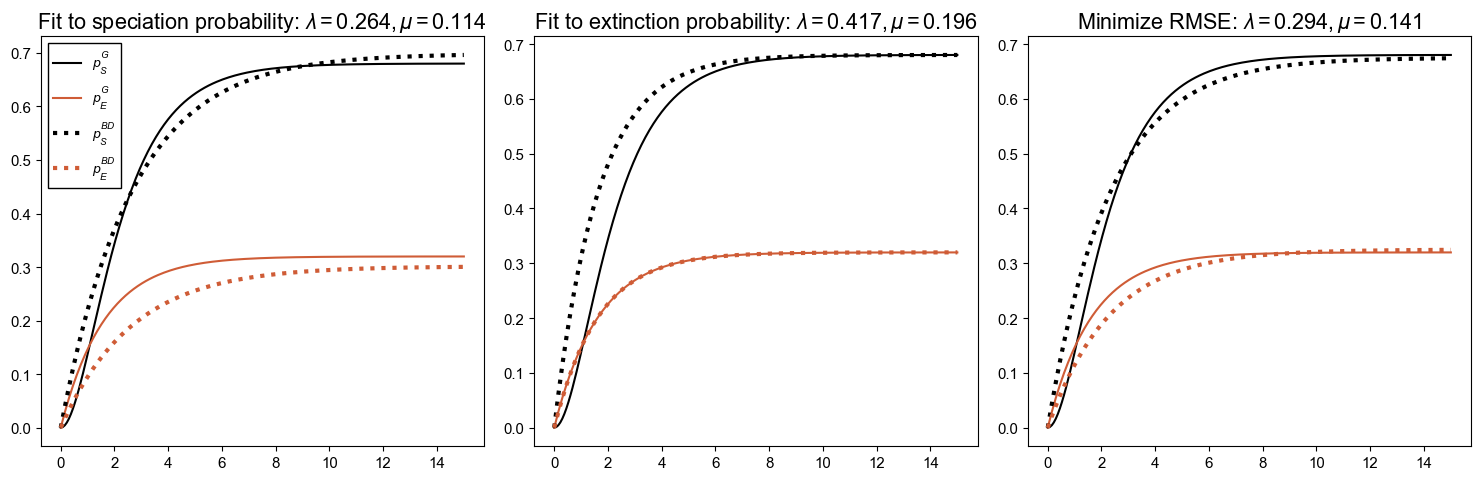

In [8]:
pGE, pGS = probs["pGE"], probs["pGS"]
pGN = 1.0 - pGE - pGS
fig, axes = plt.subplots(1,3,figsize = (15,5))

for ax in axes:
    ax.plot(probs["T"], probs["pGS"], label = "$p^G_S$")
    ax.plot(probs["T"], probs["pGE"], label = "$p^G_E$")

# Fit constant rates 
# Optimal for speciation probability
def pS_horiz_bd(t, l, m):
    pS = l / (l + m) * (1-np.exp(-(l+m)*t))
    return pS

fitS = curve_fit(pS_horiz_bd, T, pGS, p0 = (1.0,1.0))

# Optimal for extinction probability
def pE_horiz_bd(t, l, m):
    pE = m / (l + m) * (1-np.exp(-(l+m)*t))
    return pE

fitE = curve_fit(pE_horiz_bd, T, pGE, p0 = (1.0,1.0))

# Optimal for both
def SQE(lm):
    l, m = lm
    sq = np.sum(np.power(pE_horiz_bd(T, l, m) - pGE, 2)) + np.sum(np.power(pS_horiz_bd(T, l, m) - pGS, 2))
    return np.sqrt(sq)

x0 = np.mean([fitE[0], fitS[0]], axis = 0)
fitB = [scipy.optimize.minimize(SQE, x0 = x0, bounds = [(0.0, np.infty), (0.0, np.infty)])["x"]]

titles = ["Fit to speciation probability", "Fit to extinction probability", "Minimize RMSE"]

for i, fit in enumerate((fitS, fitE, fitB)):
    ax = axes[i]
    ax.plot(T, pS_horiz_bd(T, *fit[0]), color = colors[0], ls = ":", label = "$p_S^{BD}$", lw = 3)
    ax.plot(T, pE_horiz_bd(T, *fit[0]), color = colors[1], ls = ":", label = "$p_E^{BD}$", lw = 3)
    ax.set_title(titles[i] + ": $\\lambda = {:.3f}, \\mu = {:.3f}$".format(*fit[0]))
axes[0].legend(prop = dict(size = 10));

*__Figure 5.__ Speciation and extinction probabilities in the PBD model (solid lines) and in the BD model (dotted lines) with rates optimizing either speciation probability (left), extinction probability (middle) or both (right).*

  0%|          | 0/13 [00:00<?, ?it/s]

c:\Users\pveron\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
c:\Users\pveron\Documents\GitHub\PBD_analog\1-rates_analysis\../modules\PBD_analog.py:222: RuntimeWarning: invalid value encountered in sqrt
  pIE =  1/b * np.sqrt(num/den - 0.5*(l*(k-l) + 2*a*b))


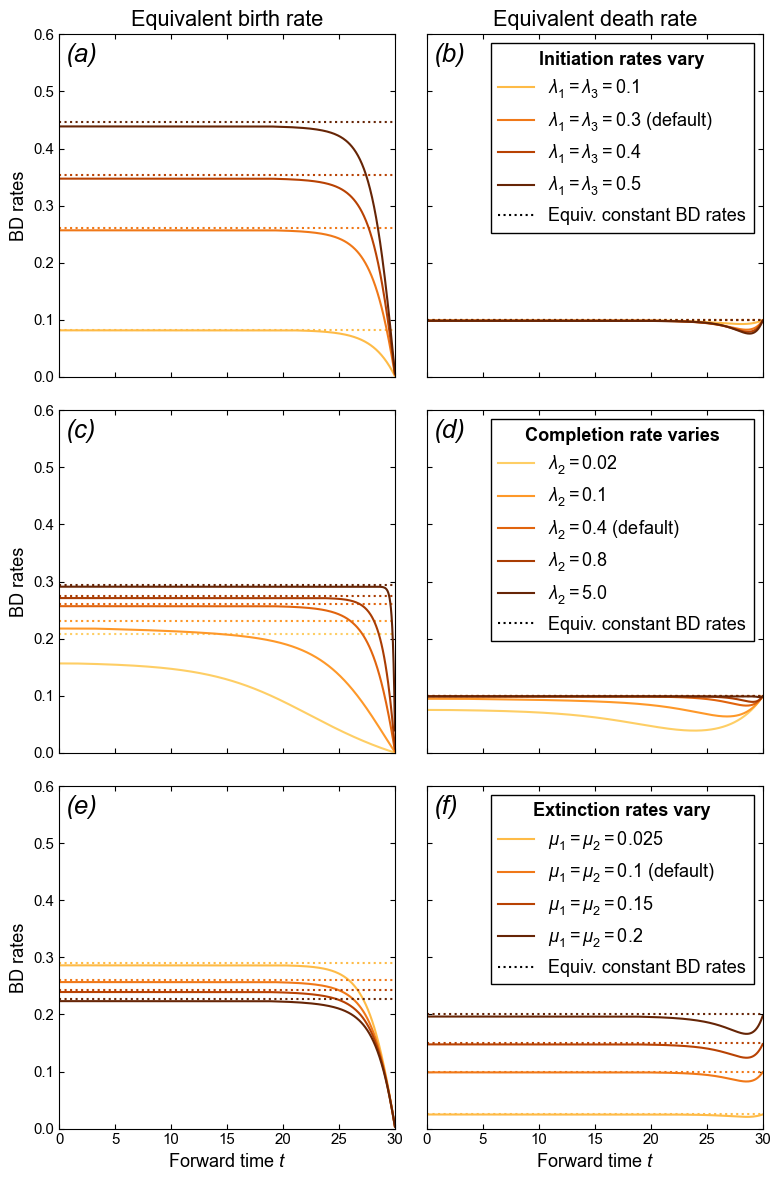

In [9]:
par = {'l1': 0.3, 'l2': 0.4, 'l3': 0.3, 'm1': 0.1, 'm2': 0.1}
solver_kwargs = dict(atol = 1e-15, rtol = 1e-15)

super_params_list = ["init", "comp", "ext"]

name_params = {'init':["l1", "l3"],
              'comp':["l2"],
              'ext':["m1", "m2"]}

par_values = {'init':[0.1, 0.3, 0.4, 0.5],
              'comp':[0.02, 0.1, 0.4, 0.8, 5.0],
              'ext':[0.025, 0.1, 0.15, 0.2]}

panels = [('(a)', '(b)'), ('(c)', '(d)'), ('(e)', '(f)')]

T = np.linspace(0, 30, 500)

labels = ["\\lambda_1 = \\lambda_3", "\\lambda_2", "\mu_1 = \\mu_2"]
legend = ["Initiation rates vary", "Completion rate varies", "Extinction rates vary"]
cmap = mpl.colormaps["YlOrBr"]
fig, axes = plt.subplots(3,2, sharex=True, sharey=True, figsize = (8,12))


pbar = tqdm(total = np.sum([len(par_values[k]) for k in par_values.keys()]))

for i, super_param  in enumerate(super_params_list):
    par_copy = par.copy()
    for j, x in enumerate(par_values[super_param]):
        is_default = True
        for par_vary in name_params[super_param]:
            par_copy[par_vary] = x
            if par[par_vary] != x:
                is_default = False
        pbar.update(1)
        l_equiv, m_equiv = PBD_analog.fixedZero_PBD_to_varBD(T, **par_copy, solver_kwargs= solver_kwargs)
        lbl = "${} = {}$".format(labels[i], x)
        if is_default:
            lbl += " (default)"
        axes[i, 0].plot(T, l_equiv, label = lbl, color = cmap((j+2) / (1+len(par_values[super_param]))))
        axes[i, 1].plot(T, m_equiv, label = lbl, color = cmap((j+2) / (1+len(par_values[super_param]))))

        # calculate constant BD rates
        CBD_rates = PBD_analog.analog_BD_rates(**par_copy, branch_at_initiation=True)
        axes[i, 0].axhline(CBD_rates[0], ls = ":", color = cmap((j+2) / (1+len(par_values[super_param]))))
        axes[i, 1].axhline(CBD_rates[1], ls = ":", color = cmap((j+2) / (1+len(par_values[super_param]))))
    axes[i, 1].plot([],[], color = 'k', ls = ":", label = "Equiv. constant BD rates")
    
    lg = axes[i, 1].legend(loc = 1, title = legend[i], title_fontproperties = dict(weight = 'bold'))
    
    axes[i, 0].set_ylabel("BD rates")
    
    for k in (0,1):
        axes[i,k].tick_params(axis = "both", direction = "in")
        axes[i,k].yaxis.set_ticks_position('both')
        
        axes[i,k].xaxis.set_ticks_position('both')
        graph_tools.name_plot_corner(axes[i,k],  panels[i][k], weight = "normal",style = "italic")

pbar.close()
    
axes[0,0].set_title("Equivalent birth rate")
axes[0,1].set_title("Equivalent death rate")

axes[-1,0].set_xlabel("Forward time $t$")
axes[-1,1].set_xlabel("Forward time $t$")


axes[0,0].set_ylim(0,0.6)
axes[0,0].set_xlim(T[0], T[-1])

plt.savefig("../fig/PBD_time_dep_rates.pdf")
plt.savefig("../fig/figure3.png")

c:\Users\pveron\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
c:\Users\pveron\Documents\GitHub\PBD_analog\1-rates_analysis\../modules\PBD_analog.py:222: RuntimeWarning: invalid value encountered in sqrt
  pIE =  1/b * np.sqrt(num/den - 0.5*(l*(k-l) + 2*a*b))


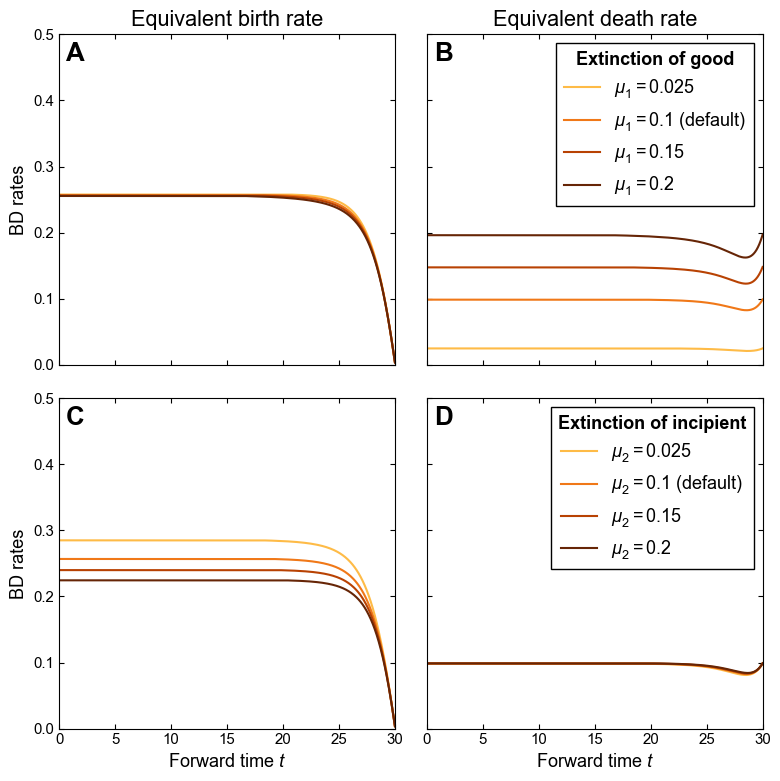

In [10]:
# Effect of extinction rates 
par = {'l1': 0.3, 'l2': 0.4, 'l3': 0.3, 'm1': 0.1, 'm2': 0.1}

name_params = ["m1", "m2"]

par_values = [0.025, 0.1, 0.15, 0.2]

panels = [('A', 'B'), ('C', 'D')]


labels = ["\mu_1", "\mu_2"]
legend = ["Extinction of good", "Extinction of incipient"]
cmap = mpl.colormaps["YlOrBr"]
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize = (8,8))

for i, par_vary  in enumerate(name_params):
    par_copy = par.copy()
    for j, x in enumerate(par_values):
        is_default = True
        
        par_copy[par_vary] = x
        if par[par_vary] != x:
            is_default = False
        l_equiv, m_equiv = PBD_analog.fixedZero_PBD_to_varBD(T, **par_copy, solver_kwargs=solver_kwargs)
        lbl = "${} = {}$".format(labels[i], x)
        if is_default:
            lbl += " (default)"
        axes[i, 0].plot(T, l_equiv, label = lbl, color = cmap((j+2) / (1+len(par_values))))
        axes[i, 1].plot(T, m_equiv, label = lbl, color = cmap((j+2) / (1+len(par_values))))
        
        # calculate constant BD rates
        CBD_rates = PBD_analog.analog_BD_rates(**par_copy, branch_at_initiation=True)

    lg = axes[i, 1].legend(loc = 1, title = legend[i], title_fontproperties = dict(weight = 'bold'))
    
    axes[i, 0].set_ylabel("BD rates")
    
    for k in (0,1):
        axes[i,k].tick_params(axis = "both", direction = "in")
        axes[i,k].yaxis.set_ticks_position('both')
        
        axes[i,k].xaxis.set_ticks_position('both')
        graph_tools.name_plot_corner(axes[i,k], panels[i][k])
    
    
axes[0,0].set_title("Equivalent birth rate")
axes[0,1].set_title("Equivalent death rate")

axes[-1,0].set_xlabel("Forward time $t$")
axes[-1,1].set_xlabel("Forward time $t$")


axes[0,0].set_ylim(0,0.5)
axes[0,0].set_xlim(T[0], T[-1])

plt.savefig("../fig/SM_time_dep_rates_extinction.pdf")

c:\Users\pveron\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
c:\Users\pveron\Documents\GitHub\PBD_analog\1-rates_analysis\../modules\PBD_analog.py:222: RuntimeWarning: invalid value encountered in sqrt
  pIE =  1/b * np.sqrt(num/den - 0.5*(l*(k-l) + 2*a*b))


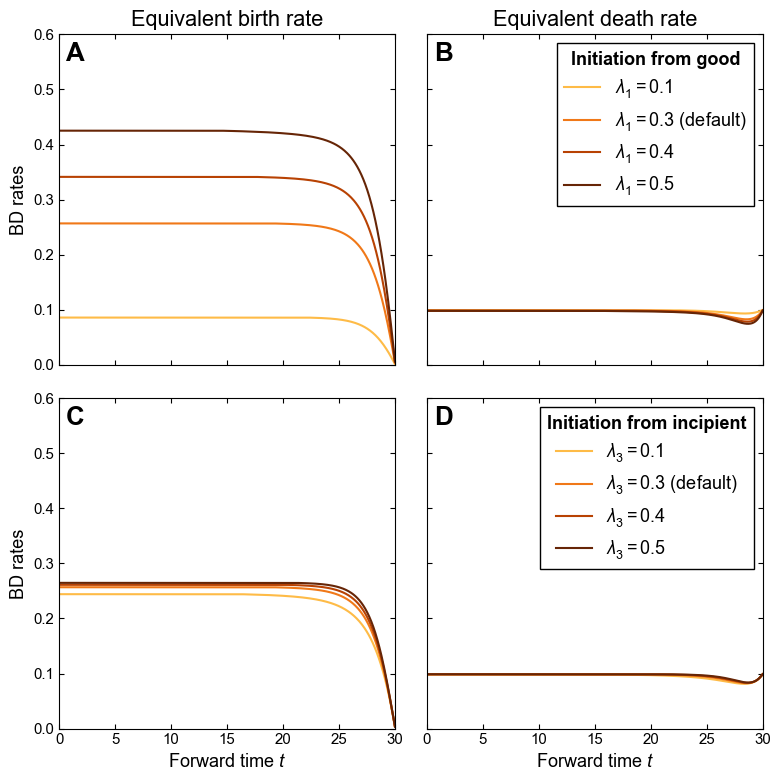

In [11]:
# Effect of extinction rates 
par = {'l1': 0.3, 'l2': 0.4, 'l3': 0.3, 'm1': 0.1, 'm2': 0.1}

name_params = ["l1", "l3"]

par_values = [0.1, 0.3, 0.4, 0.5]

panels = [('A', 'B'), ('C', 'D')]


labels = ["\\lambda_1", "\\lambda_3"]
legend = ["Initiation from good", "Initiation from incipient"]
cmap = mpl.colormaps["YlOrBr"]
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize = (8,8))

for i, par_vary  in enumerate(name_params):
    par_copy = par.copy()
    for j, x in enumerate(par_values):
        is_default = True
        
        par_copy[par_vary] = x
        if par[par_vary] != x:
            is_default = False
        l_equiv, m_equiv = PBD_analog.fixedZero_PBD_to_varBD(T, **par_copy, solver_kwargs=solver_kwargs)
        lbl = "${} = {}$".format(labels[i], x)
        if is_default:
            lbl += " (default)"
        axes[i, 0].plot(T, l_equiv, label = lbl, color = cmap((j+2) / (1+len(par_values))))
        axes[i, 1].plot(T, m_equiv, label = lbl, color = cmap((j+2) / (1+len(par_values))))
    # calculate constant BD rates
        CBD_rates = PBD_analog.analog_BD_rates(**par_copy, branch_at_initiation=True)

    lg = axes[i, 1].legend(loc = 1, title = legend[i], title_fontproperties = dict(weight = 'bold'))
    
    axes[i, 0].set_ylabel("BD rates")
    
    for k in (0,1):
        axes[i,k].tick_params(axis = "both", direction = "in")
        axes[i,k].yaxis.set_ticks_position('both')
        
        axes[i,k].xaxis.set_ticks_position('both')
        graph_tools.name_plot_corner(axes[i,k], panels[i][k])
   
    
axes[0,0].set_title("Equivalent birth rate")
axes[0,1].set_title("Equivalent death rate")

axes[-1,0].set_xlabel("Forward time $t$")
axes[-1,1].set_xlabel("Forward time $t$")

axes[0,0].set_ylim(0,0.6)
axes[0,0].set_xlim(T[0], T[-1])


plt.savefig("../fig/SM_time_dep_rates_initiation.pdf")

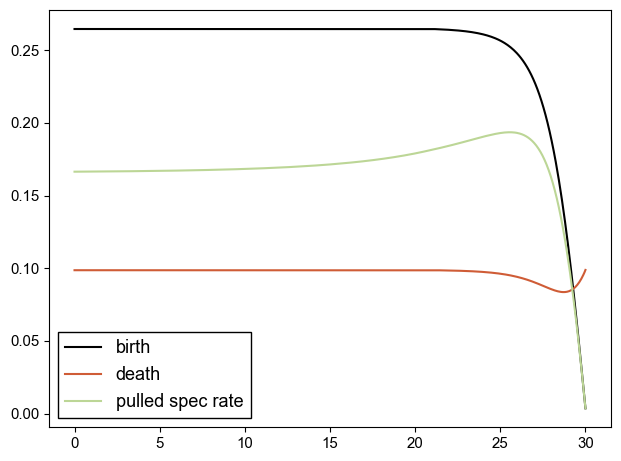

In [12]:
lambda_p = PBD_analog.pulled_spec_rate(T, l_equiv, m_equiv, rtol = 1e-9, atol = 1e-9)

fig, ax = plt.subplots()

ax.plot(T, l_equiv, label = "birth")
ax.plot(T, m_equiv, label = "death")
ax.plot(T, lambda_p, label = "pulled spec rate")
ax.legend()